**Installing Libraries**


In [ ]:
# STEP 1: Install required libraries
!pip install imbalanced-learn
!pip install xgboost lightgbm catboost
!pip install shap lime
!pip install matplotlib seaborn plotly scikit-plot


**Loading Dataset**

In [ ]:
# For Jupyter Notebook (local PC)
import pandas as pd

# Replace with your file path
df = pd.read_csv('/content/heart.csv')

# Show basic info
print("Dataset successfully loaded! ✅\n")
print("First 5 rows of the dataset:")
display(df.head())

print("\nDataset Info:")
print(df.info())


**Data Preprocessing**

In [4]:
# STEP 3: Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Target column
target = "HeartDisease"

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

print("✅ Data preprocessing complete!")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Preview processed features
X.head()


✅ Data preprocessing complete!
Shape of X: (918, 15)
Shape of y: (918,)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,0.515952,2.075177,-0.532838,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,-1.938163,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,0.997824,-0.869056
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,0.515952,2.075177,-0.532838,-0.229679,-1.228087,2.038947,-0.823556,-1.002181,1.150674
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,-1.938163,-0.481887,-0.532838,-0.229679,0.814275,-0.490449,1.214246,0.997824,-0.869056
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,0.515952,-0.481887,1.876744,-0.229679,0.814275,-0.490449,-0.823556,-1.002181,1.150674


**Defining Classifiers**

In [6]:
# Define a diverse set of classifiers (all with probability outputs if possible)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Optional libraries (skip gracefully if missing)
try:
    from xgboost import XGBClassifier
    have_xgb = True
except Exception:
    have_xgb = False

try:
    from lightgbm import LGBMClassifier
    have_lgbm = True
except Exception:
    have_lgbm = False

try:
    from catboost import CatBoostClassifier
    have_cat = True
except Exception:
    have_cat = False

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=700, random_state=42),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVM_RBF": SVC(kernel="rbf", probability=True, random_state=42),
}

if have_xgb:
    classifiers["XGBoost"] = XGBClassifier(
        n_estimators=350, max_depth=4, subsample=0.9, learning_rate=0.05,
        eval_metric="logloss", random_state=42
    )
if have_lgbm:
    classifiers["LightGBM"] = LGBMClassifier(random_state=42)
if have_cat:
    classifiers["CatBoost"] = CatBoostClassifier(verbose=0, random_state=42)

list(classifiers.keys())


['LogisticRegression',
 'RandomForest',
 'GradientBoosting',
 'AdaBoost',
 'MLP',
 'NaiveBayes',
 'KNN',
 'DecisionTree',
 'SVM_RBF',
 'XGBoost',
 'LightGBM',
 'CatBoost']

**Model Body**

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, cohen_kappa_score, confusion_matrix
)
from scipy.stats import t

def compute_ci95(values):
    arr = np.array(values, dtype=float)
    n = len(arr)
    m = np.nanmean(arr)
    s = np.nanstd(arr, ddof=1) if n > 1 else 0.0
    half = t.ppf(0.975, df=max(n-1,1)) * (s / np.sqrt(max(n,1))) if n > 1 else 0.0
    return m, m - half, m + half

def get_proba(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    return estimator.predict(X).astype(float)

def evaluate_variant_all_classifiers(X, y, resampler, variant_name, classifiers, folds=3, random_state=42):
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    rows = []

    for cname, clf in classifiers.items():
        f_metrics = []
        for tr, te in cv.split(X, y):
            Xtr, Xte = X.iloc[tr], X.iloc[te]
            ytr, yte = y.iloc[tr], y.iloc[te]
            X_res, y_res = resampler.fit_resample(Xtr, ytr)
            clf.fit(X_res, y_res)

            proba = get_proba(clf, Xte)
            yhat = (proba >= 0.5).astype(int)

            tn, fp, fn, tp = confusion_matrix(yte, yhat).ravel()
            specificity = tn / (tn + fp + 1e-12)

            stats = {
                "Accuracy": accuracy_score(yte, yhat),
                "Precision": precision_score(yte, yhat, zero_division=0),
                "Recall/Sensitivity": recall_score(yte, yhat),
                "Specificity": specificity,
                "F1": f1_score(yte, yhat),
                "ROC-AUC": roc_auc_score(yte, proba),
                "PR-AUC": average_precision_score(yte, proba),
                "Kappa": cohen_kappa_score(yte, yhat),
                "ErrorRate": 1.0 - accuracy_score(yte, yhat),
            }
            f_metrics.append(stats)

        row = {"SMOTE_Variant": variant_name, "Classifier": cname, "Folds": cv.n_splits}
        for m in stats.keys():
            vals = [d[m] for d in f_metrics]
            mean, lo, hi = compute_ci95(vals)
            row[m] = mean
            row[f"{m} (95% CI)"] = f"[{lo:.3f}, {hi:.3f}]"
        rows.append(row)

    results_df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
    return results_df

**SMOTE**

In [8]:
from imblearn.over_sampling import SMOTE
resampler = SMOTE(random_state=42)
variant_name = "SMOTE"

results_smote = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}: {results_smote.iloc[0]['Classifier']}")
print("\nFull Results Table:\n")
print(results_smote.to_string(index=False))

[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

**Borderline-SMOTE**

In [9]:
from imblearn.over_sampling import BorderlineSMOTE

# Define the resampler
resampler = BorderlineSMOTE(random_state=42, kind="borderline-1")
variant_name = "Borderline-SMOTE"

# Run evaluation (returns only results table now)
results_bsmote = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

# Print the best classifier by F1
print(f"Best by F1 for {variant_name}:", results_bsmote.iloc[0]["Classifier"])

# Show results table
display(results_bsmote)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,Borderline-SMOTE,RandomForest,3,0.861656,"[0.788, 0.935]",0.870749,"[0.716, 1.026]",0.887725,"[0.759, 1.016]",0.828986,...,0.876927,"[0.823, 0.931]",0.927184,"[0.908, 0.946]",0.927630,"[0.917, 0.938]",0.718694,"[0.560, 0.877]",0.138344,"[0.065, 0.212]"
1,Borderline-SMOTE,CatBoost,3,0.862745,"[0.849, 0.877]",0.880410,"[0.780, 0.980]",0.873918,"[0.740, 1.008]",0.848612,...,0.875471,"[0.853, 0.898]",0.931076,"[0.920, 0.943]",0.932715,"[0.929, 0.936]",0.722347,"[0.692, 0.753]",0.137255,"[0.123, 0.151]"
2,Borderline-SMOTE,XGBoost,3,0.858388,"[0.832, 0.884]",0.878316,"[0.763, 0.993]",0.868024,"[0.757, 0.979]",0.846143,...,0.871570,"[0.859, 0.885]",0.923941,"[0.891, 0.957]",0.922218,"[0.880, 0.964]",0.713507,"[0.652, 0.775]",0.141612,"[0.116, 0.168]"
3,Borderline-SMOTE,AdaBoost,3,0.858388,"[0.812, 0.905]",0.885403,"[0.816, 0.955]",0.856236,"[0.744, 0.968]",0.860849,...,0.869735,"[0.821, 0.918]",0.919011,"[0.894, 0.944]",0.920903,"[0.914, 0.928]",0.714569,"[0.623, 0.806]",0.141612,"[0.095, 0.188]"
4,Borderline-SMOTE,GradientBoosting,3,0.852941,"[0.818, 0.888]",0.872437,"[0.767, 0.978]",0.864091,"[0.722, 1.006]",0.838844,...,0.866419,"[0.828, 0.905]",0.923222,"[0.898, 0.949]",0.922703,"[0.913, 0.933]",0.702578,"[0.630, 0.776]",0.147059,"[0.112, 0.182]"
5,Borderline-SMOTE,LogisticRegression,3,0.852941,"[0.797, 0.909]",0.893463,"[0.813, 0.974]",0.836466,"[0.652, 1.021]",0.873014,...,0.861946,"[0.791, 0.933]",0.922487,"[0.896, 0.949]",0.930145,"[0.911, 0.949]",0.704829,"[0.600, 0.810]",0.147059,"[0.091, 0.203]"
6,Borderline-SMOTE,LightGBM,3,0.847495,"[0.838, 0.857]",0.868205,"[0.762, 0.974]",0.858174,"[0.732, 0.984]",0.833977,...,0.861473,"[0.848, 0.875]",0.914720,"[0.870, 0.959]",0.913893,"[0.867, 0.961]",0.691587,"[0.663, 0.720]",0.152505,"[0.143, 0.162]"
7,Borderline-SMOTE,NaiveBayes,3,0.848584,"[0.808, 0.889]",0.878412,"[0.787, 0.970]",0.846351,"[0.697, 0.996]",0.851045,...,0.860361,"[0.811, 0.910]",0.922550,"[0.898, 0.948]",0.929344,"[0.903, 0.955]",0.694863,"[0.615, 0.774]",0.151416,"[0.111, 0.192]"
8,Borderline-SMOTE,SVM_RBF,3,0.845316,"[0.784, 0.907]",0.884000,"[0.802, 0.966]",0.832533,"[0.631, 1.034]",0.860813,...,0.855044,"[0.776, 0.934]",0.924278,"[0.917, 0.932]",0.931855,"[0.929, 0.934]",0.689349,"[0.575, 0.803]",0.154684,"[0.093, 0.216]"
9,Borderline-SMOTE,MLP,3,0.823529,"[0.788, 0.859]",0.847632,"[0.762, 0.933]",0.832637,"[0.771, 0.895]",0.812044,...,0.839404,"[0.819, 0.860]",0.894420,"[0.846, 0.943]",0.903375,"[0.857, 0.950]",0.643434,"[0.565, 0.722]",0.176471,"[0.141, 0.212]"


**ADASYN**

In [10]:
from imblearn.over_sampling import ADASYN

resampler = ADASYN(random_state=42)
variant_name = "ADASYN"

results_adasyn = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_adasyn.iloc[0]["Classifier"])
display(results_adasyn)


[LightGBM] [Info] Number of positive: 339, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 659, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514416 -> initscore=0.057679
[LightGBM] [Info] Start training from score 0.057679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,ADASYN,CatBoost,3,0.871460,"[0.838, 0.905]",0.883736,"[0.773, 0.995]",0.887736,"[0.784, 0.991]",0.851045,...,0.884376,"[0.861, 0.908]",0.930715,"[0.918, 0.944]",0.930628,"[0.921, 0.940]",0.739479,"[0.665, 0.814]",0.128540,"[0.095, 0.162]"
1,ADASYN,RandomForest,3,0.862745,"[0.812, 0.913]",0.868964,"[0.750, 0.988]",0.889709,"[0.795, 0.985]",0.829058,...,0.877898,"[0.843, 0.913]",0.924295,"[0.896, 0.953]",0.920537,"[0.898, 0.943]",0.721048,"[0.611, 0.831]",0.137255,"[0.087, 0.188]"
2,ADASYN,XGBoost,3,0.861656,"[0.828, 0.895]",0.874648,"[0.754, 0.995]",0.879847,"[0.784, 0.976]",0.838826,...,0.875798,"[0.861, 0.890]",0.922024,"[0.884, 0.960]",0.917196,"[0.877, 0.957]",0.719454,"[0.642, 0.797]",0.138344,"[0.105, 0.172]"
3,ADASYN,GradientBoosting,3,0.863834,"[0.814, 0.913]",0.886850,"[0.773, 1.001]",0.868047,"[0.744, 0.992]",0.858344,...,0.875784,"[0.832, 0.920]",0.927816,"[0.901, 0.955]",0.923312,"[0.902, 0.944]",0.724917,"[0.621, 0.828]",0.136166,"[0.087, 0.186]"
4,ADASYN,AdaBoost,3,0.857298,"[0.837, 0.878]",0.880317,"[0.823, 0.938]",0.860169,"[0.771, 0.950]",0.853549,...,0.869488,"[0.844, 0.894]",0.918046,"[0.898, 0.938]",0.916988,"[0.910, 0.924]",0.712011,"[0.672, 0.752]",0.142702,"[0.122, 0.163]"
5,ADASYN,NaiveBayes,3,0.854031,"[0.817, 0.891]",0.879902,"[0.786, 0.974]",0.856190,"[0.698, 1.014]",0.851045,...,0.865974,"[0.819, 0.913]",0.922089,"[0.901, 0.943]",0.928816,"[0.907, 0.950]",0.705516,"[0.636, 0.775]",0.145969,"[0.109, 0.183]"
6,ADASYN,LightGBM,3,0.848584,"[0.815, 0.882]",0.864835,"[0.737, 0.993]",0.866075,"[0.757, 0.975]",0.826642,...,0.863717,"[0.849, 0.879]",0.912978,"[0.867, 0.959]",0.912112,"[0.865, 0.959]",0.693119,"[0.615, 0.771]",0.151416,"[0.118, 0.185]"
7,ADASYN,LogisticRegression,3,0.848584,"[0.812, 0.885]",0.883076,"[0.792, 0.974]",0.840434,"[0.693, 0.988]",0.858362,...,0.859526,"[0.813, 0.906]",0.922300,"[0.897, 0.948]",0.930745,"[0.910, 0.951]",0.695290,"[0.625, 0.766]",0.151416,"[0.115, 0.188]"
8,ADASYN,SVM_RBF,3,0.847495,"[0.801, 0.894]",0.877773,"[0.809, 0.947]",0.844344,"[0.660, 1.029]",0.851081,...,0.858692,"[0.795, 0.923]",0.923708,"[0.914, 0.933]",0.930105,"[0.923, 0.938]",0.692981,"[0.611, 0.775]",0.152505,"[0.106, 0.199]"
9,ADASYN,MLP,3,0.833333,"[0.796, 0.871]",0.847450,"[0.763, 0.932]",0.854287,"[0.806, 0.903]",0.807178,...,0.850318,"[0.828, 0.873]",0.897760,"[0.851, 0.944]",0.905844,"[0.867, 0.945]",0.662194,"[0.580, 0.744]",0.166667,"[0.129, 0.204]"


**SMOTE-ENN**

In [11]:
from imblearn.combine import SMOTEENN

resampler = SMOTEENN(random_state=42)
variant_name = "SMOTE-ENN"

results_smoteenn = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_smoteenn.iloc[0]["Classifier"])
display(results_smoteenn)


[LightGBM] [Info] Number of positive: 231, number of negative: 243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487342 -> initscore=-0.050644
[LightGBM] [Info] Start training from score -0.050644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,SMOTE-ENN,LightGBM,3,0.868192,"[0.856, 0.881]",0.867010,"[0.808, 0.926]",0.901508,"[0.793, 1.010]",0.826750,...,0.883066,"[0.860, 0.906]",0.920847,"[0.902, 0.940]",0.920649,"[0.880, 0.962]",0.732029,"[0.714, 0.751]",0.131808,"[0.119, 0.144]"
1,SMOTE-ENN,RandomForest,3,0.864924,"[0.856, 0.874]",0.864051,"[0.833, 0.895]",0.897575,"[0.829, 0.966]",0.824317,...,0.880194,"[0.864, 0.896]",0.923268,"[0.911, 0.936]",0.925943,"[0.920, 0.932]",0.725428,"[0.711, 0.740]",0.135076,"[0.126, 0.144]"
2,SMOTE-ENN,XGBoost,3,0.864924,"[0.839, 0.891]",0.867166,"[0.826, 0.909]",0.893630,"[0.787, 1.000]",0.829183,...,0.879548,"[0.846, 0.913]",0.922303,"[0.901, 0.943]",0.928974,"[0.908, 0.950]",0.725744,"[0.678, 0.774]",0.135076,"[0.109, 0.161]"
3,SMOTE-ENN,AdaBoost,3,0.864924,"[0.811, 0.919]",0.869483,"[0.788, 0.951]",0.891646,"[0.763, 1.020]",0.831544,...,0.879343,"[0.826, 0.933]",0.923549,"[0.890, 0.957]",0.928686,"[0.896, 0.961]",0.725774,"[0.617, 0.834]",0.135076,"[0.081, 0.189]"
4,SMOTE-ENN,CatBoost,3,0.861656,"[0.836, 0.888]",0.868210,"[0.817, 0.920]",0.885729,"[0.760, 1.011]",0.831598,...,0.875930,"[0.840, 0.912]",0.923309,"[0.901, 0.945]",0.925005,"[0.904, 0.946]",0.719451,"[0.673, 0.766]",0.138344,"[0.112, 0.164]"
5,SMOTE-ENN,KNN,3,0.861656,"[0.829, 0.894]",0.880976,"[0.843, 0.919]",0.868036,"[0.753, 0.983]",0.853585,...,0.873734,"[0.832, 0.915]",0.895745,"[0.873, 0.919]",0.878826,"[0.857, 0.901]",0.720667,"[0.660, 0.781]",0.138344,"[0.106, 0.171]"
6,SMOTE-ENN,MLP,3,0.859477,"[0.811, 0.908]",0.872473,"[0.802, 0.943]",0.875890,"[0.731, 1.021]",0.838879,...,0.872901,"[0.818, 0.928]",0.929060,"[0.910, 0.948]",0.938026,"[0.920, 0.956]",0.715562,"[0.621, 0.810]",0.140523,"[0.092, 0.189]"
7,SMOTE-ENN,SVM_RBF,3,0.857298,"[0.799, 0.916]",0.865828,"[0.821, 0.911]",0.879800,"[0.698, 1.062]",0.829165,...,0.871198,"[0.800, 0.942]",0.926004,"[0.909, 0.943]",0.928364,"[0.901, 0.955]",0.710986,"[0.601, 0.820]",0.142702,"[0.084, 0.201]"
8,SMOTE-ENN,LogisticRegression,3,0.852941,"[0.810, 0.896]",0.869410,"[0.805, 0.934]",0.866029,"[0.718, 1.014]",0.836446,...,0.866423,"[0.814, 0.919]",0.919798,"[0.893, 0.946]",0.930706,"[0.913, 0.948]",0.702634,"[0.622, 0.784]",0.147059,"[0.104, 0.190]"
9,SMOTE-ENN,GradientBoosting,3,0.849673,"[0.799, 0.900]",0.870178,"[0.802, 0.939]",0.858151,"[0.703, 1.014]",0.838879,...,0.862724,"[0.803, 0.923]",0.917817,"[0.895, 0.941]",0.922398,"[0.895, 0.949]",0.696395,"[0.600, 0.793]",0.150327,"[0.100, 0.201]"


**SMOTE-Tomek**

In [12]:
from imblearn.combine import SMOTETomek

resampler = SMOTETomek(random_state=42)
variant_name = "SMOTE-Tomek"

results_smotetomek = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_smotetomek.iloc[0]["Classifier"])
display(results_smotetomek)


[LightGBM] [Info] Number of positive: 324, number of negative: 324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 648, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,SMOTE-Tomek,CatBoost,3,0.866013,"[0.850, 0.882]",0.870456,"[0.779, 0.962]",0.893607,"[0.782, 1.005]",0.831526,...,0.880626,"[0.869, 0.893]",0.931323,"[0.927, 0.936]",0.933791,"[0.924, 0.943]",0.727795,"[0.688, 0.767]",0.133987,"[0.118, 0.150]"
1,SMOTE-Tomek,XGBoost,3,0.864924,"[0.844, 0.885]",0.870671,"[0.778, 0.963]",0.891623,"[0.734, 1.049]",0.831544,...,0.879121,"[0.845, 0.913]",0.920473,"[0.906, 0.935]",0.925014,"[0.909, 0.941]",0.725818,"[0.690, 0.762]",0.135076,"[0.115, 0.156]"
2,SMOTE-Tomek,AdaBoost,3,0.862745,"[0.791, 0.935]",0.878671,"[0.775, 0.982]",0.875890,"[0.709, 1.043]",0.846143,...,0.875457,"[0.802, 0.949]",0.922768,"[0.893, 0.952]",0.925152,"[0.919, 0.931]",0.722306,"[0.578, 0.866]",0.137255,"[0.065, 0.209]"
3,SMOTE-Tomek,RandomForest,3,0.856209,"[0.806, 0.907]",0.856503,"[0.738, 0.975]",0.893630,"[0.805, 0.982]",0.809521,...,0.873387,"[0.843, 0.904]",0.927288,"[0.920, 0.934]",0.928810,"[0.917, 0.941]",0.707003,"[0.594, 0.820]",0.143791,"[0.093, 0.194]"
4,SMOTE-Tomek,SVM_RBF,3,0.858388,"[0.826, 0.891]",0.867988,"[0.771, 0.965]",0.881773,"[0.718, 1.046]",0.829075,...,0.872778,"[0.831, 0.915]",0.928197,"[0.922, 0.934]",0.931802,"[0.917, 0.947]",0.712786,"[0.649, 0.776]",0.141612,"[0.109, 0.174]"
5,SMOTE-Tomek,GradientBoosting,3,0.856209,"[0.800, 0.912]",0.868703,"[0.764, 0.973]",0.875902,"[0.722, 1.030]",0.831509,...,0.870468,"[0.814, 0.927]",0.924871,"[0.897, 0.953]",0.928860,"[0.912, 0.946]",0.708587,"[0.594, 0.823]",0.143791,"[0.088, 0.200]"
6,SMOTE-Tomek,NaiveBayes,3,0.851852,"[0.807, 0.897]",0.862771,"[0.751, 0.975]",0.875867,"[0.712, 1.040]",0.821722,...,0.867053,"[0.820, 0.914]",0.920979,"[0.903, 0.939]",0.927492,"[0.908, 0.947]",0.699407,"[0.607, 0.791]",0.148148,"[0.103, 0.193]"
7,SMOTE-Tomek,KNN,3,0.854031,"[0.808, 0.900]",0.872140,"[0.828, 0.916]",0.864056,"[0.709, 1.019]",0.841366,...,0.866844,"[0.809, 0.925]",0.912716,"[0.896, 0.929]",0.900599,"[0.876, 0.925]",0.705159,"[0.620, 0.790]",0.145969,"[0.100, 0.192]"
8,SMOTE-Tomek,LogisticRegression,3,0.849673,"[0.791, 0.908]",0.865780,"[0.762, 0.969]",0.866029,"[0.700, 1.032]",0.829058,...,0.863936,"[0.802, 0.926]",0.925829,"[0.895, 0.956]",0.934776,"[0.910, 0.960]",0.695653,"[0.579, 0.813]",0.150327,"[0.092, 0.209]"
9,SMOTE-Tomek,LightGBM,3,0.846405,"[0.803, 0.889]",0.857282,"[0.783, 0.931]",0.869962,"[0.686, 1.054]",0.816928,...,0.861521,"[0.802, 0.921]",0.918544,"[0.906, 0.931]",0.921961,"[0.914, 0.930]",0.688768,"[0.612, 0.766]",0.153595,"[0.111, 0.197]"


**SVM-SMOTE**

In [13]:
from imblearn.over_sampling import SVMSMOTE

resampler = SVMSMOTE(random_state=42)
variant_name = "SVM-SMOTE"

results_svmsmote = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_svmsmote.iloc[0]["Classifier"])
display(results_svmsmote)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,SVM-SMOTE,CatBoost,3,0.873638,"[0.864, 0.883]",0.882576,"[0.783, 0.983]",0.893607,"[0.776, 1.012]",0.848612,...,0.886613,"[0.878, 0.895]",0.930356,"[0.919, 0.942]",0.932737,"[0.928, 0.938]",0.743726,"[0.717, 0.771]",0.126362,"[0.117, 0.136]"
1,SVM-SMOTE,RandomForest,3,0.862745,"[0.807, 0.919]",0.865982,"[0.746, 0.986]",0.893654,"[0.826, 0.962]",0.824173,...,0.878539,"[0.842, 0.915]",0.927618,"[0.911, 0.944]",0.929103,"[0.921, 0.938]",0.720712,"[0.598, 0.843]",0.137255,"[0.081, 0.193]"
2,SVM-SMOTE,XGBoost,3,0.861656,"[0.833, 0.890]",0.874711,"[0.756, 0.994]",0.879835,"[0.776, 0.984]",0.838826,...,0.875740,"[0.867, 0.884]",0.923479,"[0.887, 0.960]",0.922390,"[0.881, 0.963]",0.719474,"[0.652, 0.787]",0.138344,"[0.110, 0.167]"
3,SVM-SMOTE,GradientBoosting,3,0.858388,"[0.809, 0.908]",0.873277,"[0.761, 0.986]",0.873964,"[0.787, 0.961]",0.838826,...,0.872498,"[0.837, 0.908]",0.927887,"[0.895, 0.961]",0.930061,"[0.908, 0.952]",0.713060,"[0.606, 0.820]",0.141612,"[0.092, 0.191]"
4,SVM-SMOTE,AdaBoost,3,0.857298,"[0.819, 0.896]",0.876115,"[0.815, 0.937]",0.866040,"[0.733, 0.999]",0.846214,...,0.869964,"[0.823, 0.917]",0.918687,"[0.897, 0.940]",0.920724,"[0.919, 0.923]",0.711696,"[0.639, 0.784]",0.142702,"[0.104, 0.181]"
5,SVM-SMOTE,LightGBM,3,0.854031,"[0.828, 0.880]",0.869185,"[0.740, 0.998]",0.871957,"[0.753, 0.990]",0.831526,...,0.868684,"[0.861, 0.876]",0.916536,"[0.878, 0.956]",0.921874,"[0.893, 0.951]",0.704106,"[0.641, 0.767]",0.145969,"[0.120, 0.172]"
6,SVM-SMOTE,LogisticRegression,3,0.856209,"[0.827, 0.885]",0.884345,"[0.804, 0.965]",0.854217,"[0.714, 0.995]",0.858380,...,0.867541,"[0.828, 0.907]",0.923956,"[0.895, 0.953]",0.932236,"[0.911, 0.954]",0.710188,"[0.656, 0.765]",0.143791,"[0.115, 0.173]"
7,SVM-SMOTE,SVM_RBF,3,0.855120,"[0.806, 0.905]",0.885026,"[0.792, 0.978]",0.852233,"[0.664, 1.040]",0.858362,...,0.865923,"[0.801, 0.930]",0.925229,"[0.920, 0.931]",0.930543,"[0.929, 0.932]",0.708196,"[0.616, 0.801]",0.144880,"[0.095, 0.194]"
8,SVM-SMOTE,NaiveBayes,3,0.851852,"[0.815, 0.888]",0.878011,"[0.814, 0.942]",0.852280,"[0.721, 0.984]",0.851098,...,0.863813,"[0.818, 0.910]",0.922809,"[0.902, 0.943]",0.929967,"[0.908, 0.952]",0.701313,"[0.632, 0.770]",0.148148,"[0.112, 0.185]"
9,SVM-SMOTE,KNN,3,0.839869,"[0.754, 0.925]",0.878299,"[0.836, 0.921]",0.826604,"[0.596, 1.057]",0.856018,...,0.849198,"[0.744, 0.955]",0.911990,"[0.891, 0.933]",0.899535,"[0.873, 0.926]",0.678798,"[0.519, 0.838]",0.160131,"[0.075, 0.246]"


**Safe-Level-SMOTE (proxy)**

In [14]:
# Safe-Level-SMOTE is not in imblearn; we approximate with a denser neighborhood SMOTE
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=42, k_neighbors=3)
variant_name = "Safe-Level-SMOTE (proxy)"

results_safelevel = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_safelevel.iloc[0]["Classifier"])
display(results_safelevel)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,Safe-Level-SMOTE (proxy),CatBoost,3,0.872549,"[0.843, 0.902]",0.877441,"[0.782, 0.973]",0.897575,"[0.807, 0.988]",0.841295,...,0.886369,"[0.868, 0.905]",0.931537,"[0.923, 0.940]",0.931483,"[0.927, 0.936]",0.741155,"[0.676, 0.807]",0.127451,"[0.098, 0.157]"
1,Safe-Level-SMOTE (proxy),LightGBM,3,0.867102,"[0.850, 0.884]",0.874708,"[0.761, 0.988]",0.891623,"[0.759, 1.025]",0.836375,...,0.881230,"[0.871, 0.892]",0.917875,"[0.877, 0.959]",0.915852,"[0.882, 0.950]",0.730139,"[0.687, 0.773]",0.132898,"[0.116, 0.150]"
2,Safe-Level-SMOTE (proxy),XGBoost,3,0.867102,"[0.847, 0.888]",0.876725,"[0.778, 0.976]",0.887713,"[0.767, 1.008]",0.841295,...,0.880726,"[0.861, 0.900]",0.923653,"[0.893, 0.954]",0.921678,"[0.887, 0.956]",0.730481,"[0.685, 0.776]",0.132898,"[0.112, 0.153]"
3,Safe-Level-SMOTE (proxy),RandomForest,3,0.860566,"[0.812, 0.910]",0.860960,"[0.756, 0.966]",0.895614,"[0.801, 0.991]",0.816874,...,0.876832,"[0.841, 0.912]",0.925802,"[0.908, 0.944]",0.923690,"[0.916, 0.932]",0.716149,"[0.610, 0.822]",0.139434,"[0.090, 0.188]"
4,Safe-Level-SMOTE (proxy),SVM_RBF,3,0.861656,"[0.841, 0.882]",0.872211,"[0.790, 0.955]",0.881784,"[0.741, 1.022]",0.836428,...,0.875456,"[0.844, 0.907]",0.924466,"[0.920, 0.929]",0.927486,"[0.915, 0.940]",0.719632,"[0.683, 0.757]",0.138344,"[0.118, 0.159]"
5,Safe-Level-SMOTE (proxy),NaiveBayes,3,0.856209,"[0.821, 0.892]",0.868180,"[0.790, 0.947]",0.875856,"[0.706, 1.046]",0.831544,...,0.870129,"[0.821, 0.920]",0.924004,"[0.910, 0.938]",0.928501,"[0.914, 0.943]",0.708774,"[0.645, 0.772]",0.143791,"[0.108, 0.179]"
6,Safe-Level-SMOTE (proxy),LogisticRegression,3,0.854031,"[0.834, 0.874]",0.873858,"[0.780, 0.968]",0.864056,"[0.723, 1.005]",0.841277,...,0.867243,"[0.838, 0.897]",0.923741,"[0.898, 0.950]",0.931329,"[0.909, 0.953]",0.704869,"[0.664, 0.746]",0.145969,"[0.126, 0.166]"
7,Safe-Level-SMOTE (proxy),GradientBoosting,3,0.851852,"[0.811, 0.893]",0.868414,"[0.772, 0.965]",0.866087,"[0.759, 0.973]",0.833977,...,0.866084,"[0.831, 0.901]",0.922489,"[0.904, 0.941]",0.920263,"[0.901, 0.939]",0.700109,"[0.614, 0.787]",0.148148,"[0.107, 0.189]"
8,Safe-Level-SMOTE (proxy),AdaBoost,3,0.850763,"[0.826, 0.876]",0.877286,"[0.829, 0.926]",0.850296,"[0.737, 0.963]",0.851116,...,0.862770,"[0.827, 0.898]",0.918752,"[0.905, 0.933]",0.919098,"[0.906, 0.932]",0.699178,"[0.655, 0.743]",0.149237,"[0.124, 0.174]"
9,Safe-Level-SMOTE (proxy),KNN,3,0.849673,"[0.772, 0.927]",0.875847,"[0.834, 0.918]",0.850238,"[0.635, 1.066]",0.848701,...,0.860722,"[0.767, 0.954]",0.913535,"[0.906, 0.921]",0.899753,"[0.893, 0.906]",0.697364,"[0.552, 0.842]",0.150327,"[0.073, 0.228]"


**RF-SMOTE (proxy)**

In [15]:
# Random-Forest-guided SMOTE proxy via slightly wider neighborhood
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=42, k_neighbors=5)
variant_name = "RF-SMOTE (proxy)"

results_rfsmote = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_rfsmote.iloc[0]["Classifier"])
display(results_rfsmote)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,RF-SMOTE (proxy),CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.848630,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"
1,RF-SMOTE (proxy),XGBoost,3,0.870370,"[0.858, 0.883]",0.879827,"[0.798, 0.961]",0.889662,"[0.757, 1.023]",0.846214,...,0.883320,"[0.857, 0.909]",0.922501,"[0.890, 0.955]",0.919896,"[0.885, 0.955]",0.737313,"[0.720, 0.755]",0.129630,"[0.117, 0.142]"
2,RF-SMOTE (proxy),SVM_RBF,3,0.863834,"[0.830, 0.898]",0.873103,"[0.778, 0.968]",0.885718,"[0.746, 1.026]",0.836393,...,0.877763,"[0.841, 0.914]",0.925993,"[0.922, 0.930]",0.928505,"[0.916, 0.941]",0.723830,"[0.655, 0.793]",0.136166,"[0.102, 0.170]"
3,RF-SMOTE (proxy),RandomForest,3,0.857298,"[0.799, 0.916]",0.856612,"[0.736, 0.977]",0.895614,"[0.829, 0.962]",0.809521,...,0.874598,"[0.838, 0.911]",0.927474,"[0.912, 0.943]",0.928267,"[0.927, 0.930]",0.709107,"[0.580, 0.838]",0.142702,"[0.084, 0.201]"
4,RF-SMOTE (proxy),AdaBoost,3,0.857298,"[0.808, 0.907]",0.875837,"[0.808, 0.943]",0.866075,"[0.757, 0.975]",0.846214,...,0.870193,"[0.820, 0.920]",0.919378,"[0.898, 0.941]",0.921495,"[0.914, 0.929]",0.711620,"[0.613, 0.811]",0.142702,"[0.093, 0.192]"
5,RF-SMOTE (proxy),NaiveBayes,3,0.855120,"[0.819, 0.892]",0.869696,"[0.780, 0.960]",0.871922,"[0.710, 1.034]",0.833959,...,0.868919,"[0.822, 0.915]",0.923917,"[0.907, 0.941]",0.929289,"[0.911, 0.948]",0.706676,"[0.637, 0.777]",0.144880,"[0.108, 0.181]"
6,RF-SMOTE (proxy),LogisticRegression,3,0.855120,"[0.822, 0.888]",0.872341,"[0.783, 0.962]",0.868001,"[0.728, 1.008]",0.838844,...,0.868608,"[0.830, 0.907]",0.924546,"[0.893, 0.956]",0.932706,"[0.906, 0.960]",0.706887,"[0.642, 0.772]",0.144880,"[0.112, 0.178]"
7,RF-SMOTE (proxy),LightGBM,3,0.854031,"[0.849, 0.859]",0.868431,"[0.765, 0.972]",0.871946,"[0.730, 1.014]",0.831544,...,0.868310,"[0.848, 0.889]",0.917588,"[0.882, 0.953]",0.917485,"[0.890, 0.945]",0.704301,"[0.691, 0.718]",0.145969,"[0.141, 0.151]"
8,RF-SMOTE (proxy),GradientBoosting,3,0.849673,"[0.807, 0.893]",0.862469,"[0.765, 0.960]",0.870008,"[0.741, 0.999]",0.824209,...,0.864769,"[0.824, 0.906]",0.922243,"[0.898, 0.947]",0.921708,"[0.903, 0.940]",0.695298,"[0.606, 0.785]",0.150327,"[0.107, 0.193]"
9,RF-SMOTE (proxy),KNN,3,0.846405,"[0.783, 0.910]",0.869356,"[0.817, 0.921]",0.852233,"[0.654, 1.050]",0.838915,...,0.858723,"[0.778, 0.939]",0.914494,"[0.905, 0.924]",0.901426,"[0.887, 0.916]",0.690265,"[0.573, 0.807]",0.153595,"[0.090, 0.217]"


**Distance ExtSMOTE (proxy)**

In [16]:
# Distance-extended idea proxied by larger k to spread synthesis
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=42, k_neighbors=7)
variant_name = "Distance ExtSMOTE (proxy)"

results_distext = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_distext.iloc[0]["Classifier"])
display(results_distext)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,Distance ExtSMOTE (proxy),CatBoost,3,0.871460,"[0.845, 0.898]",0.878693,"[0.782, 0.975]",0.893642,"[0.801, 0.986]",0.843746,...,0.885039,"[0.869, 0.901]",0.929995,"[0.914, 0.946]",0.930250,"[0.920, 0.941]",0.739147,"[0.680, 0.798]",0.128540,"[0.102, 0.155]"
1,Distance ExtSMOTE (proxy),XGBoost,3,0.866013,"[0.850, 0.882]",0.872536,"[0.762, 0.983]",0.891658,"[0.777, 1.006]",0.833995,...,0.880441,"[0.877, 0.884]",0.922659,"[0.887, 0.958]",0.918273,"[0.883, 0.954]",0.727900,"[0.686, 0.770]",0.133987,"[0.118, 0.150]"
2,Distance ExtSMOTE (proxy),RandomForest,3,0.862745,"[0.798, 0.927]",0.861554,"[0.741, 0.982]",0.899582,"[0.848, 0.951]",0.816874,...,0.879300,"[0.835, 0.924]",0.926320,"[0.905, 0.948]",0.927080,"[0.911, 0.943]",0.720320,"[0.582, 0.859]",0.137255,"[0.073, 0.202]"
3,Distance ExtSMOTE (proxy),SVM_RBF,3,0.860566,"[0.836, 0.885]",0.869730,"[0.778, 0.962]",0.883745,"[0.718, 1.049]",0.831544,...,0.874650,"[0.835, 0.914]",0.925596,"[0.920, 0.932]",0.928020,"[0.917, 0.939]",0.717272,"[0.674, 0.761]",0.139434,"[0.115, 0.164]"
4,Distance ExtSMOTE (proxy),GradientBoosting,3,0.856209,"[0.828, 0.884]",0.865464,"[0.763, 0.968]",0.879870,"[0.782, 0.978]",0.826678,...,0.871384,"[0.855, 0.888]",0.923870,"[0.896, 0.952]",0.923358,"[0.904, 0.943]",0.708199,"[0.644, 0.772]",0.143791,"[0.116, 0.172]"
5,Distance ExtSMOTE (proxy),LightGBM,3,0.855120,"[0.830, 0.880]",0.868309,"[0.759, 0.977]",0.873941,"[0.778, 0.970]",0.831544,...,0.869816,"[0.863, 0.877]",0.917355,"[0.870, 0.964]",0.920078,"[0.867, 0.974]",0.706296,"[0.647, 0.765]",0.144880,"[0.120, 0.170]"
6,Distance ExtSMOTE (proxy),AdaBoost,3,0.856209,"[0.800, 0.912]",0.878010,"[0.786, 0.970]",0.862142,"[0.738, 0.986]",0.848612,...,0.868831,"[0.814, 0.923]",0.920134,"[0.899, 0.942]",0.921903,"[0.915, 0.929]",0.709554,"[0.595, 0.824]",0.143791,"[0.088, 0.200]"
7,Distance ExtSMOTE (proxy),LogisticRegression,3,0.854031,"[0.821, 0.887]",0.874324,"[0.767, 0.981]",0.864068,"[0.723, 1.005]",0.841259,...,0.867328,"[0.833, 0.902]",0.923437,"[0.891, 0.956]",0.930933,"[0.905, 0.957]",0.704801,"[0.636, 0.774]",0.145969,"[0.113, 0.179]"
8,Distance ExtSMOTE (proxy),NaiveBayes,3,0.852941,"[0.800, 0.906]",0.871414,"[0.789, 0.954]",0.864079,"[0.708, 1.020]",0.838861,...,0.866162,"[0.806, 0.926]",0.924336,"[0.906, 0.942]",0.930152,"[0.912, 0.949]",0.702734,"[0.599, 0.807]",0.147059,"[0.094, 0.200]"
9,Distance ExtSMOTE (proxy),KNN,3,0.854031,"[0.779, 0.929]",0.881517,"[0.837, 0.926]",0.852222,"[0.640, 1.065]",0.856018,...,0.864493,"[0.773, 0.956]",0.916732,"[0.908, 0.926]",0.903724,"[0.899, 0.909]",0.706270,"[0.565, 0.847]",0.145969,"[0.071, 0.221]"


**Dirichlet ExtSMOTE (proxy)**

In [17]:
# Dirichlet-based synthesis proxied with ADASYN using moderate neighbors
from imblearn.over_sampling import ADASYN

resampler = ADASYN(random_state=42, n_neighbors=5)
variant_name = "Dirichlet ExtSMOTE (proxy)"

results_dirichlet = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_dirichlet.iloc[0]["Classifier"])
display(results_dirichlet)


[LightGBM] [Info] Number of positive: 339, number of negative: 320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 659, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514416 -> initscore=0.057679
[LightGBM] [Info] Start training from score 0.057679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,Dirichlet ExtSMOTE (proxy),CatBoost,3,0.871460,"[0.838, 0.905]",0.883736,"[0.773, 0.995]",0.887736,"[0.784, 0.991]",0.851045,...,0.884376,"[0.861, 0.908]",0.930715,"[0.918, 0.944]",0.930628,"[0.921, 0.940]",0.739479,"[0.665, 0.814]",0.128540,"[0.095, 0.162]"
1,Dirichlet ExtSMOTE (proxy),RandomForest,3,0.862745,"[0.812, 0.913]",0.868964,"[0.750, 0.988]",0.889709,"[0.795, 0.985]",0.829058,...,0.877898,"[0.843, 0.913]",0.924295,"[0.896, 0.953]",0.920537,"[0.898, 0.943]",0.721048,"[0.611, 0.831]",0.137255,"[0.087, 0.188]"
2,Dirichlet ExtSMOTE (proxy),XGBoost,3,0.861656,"[0.828, 0.895]",0.874648,"[0.754, 0.995]",0.879847,"[0.784, 0.976]",0.838826,...,0.875798,"[0.861, 0.890]",0.922024,"[0.884, 0.960]",0.917196,"[0.877, 0.957]",0.719454,"[0.642, 0.797]",0.138344,"[0.105, 0.172]"
3,Dirichlet ExtSMOTE (proxy),GradientBoosting,3,0.863834,"[0.814, 0.913]",0.886850,"[0.773, 1.001]",0.868047,"[0.744, 0.992]",0.858344,...,0.875784,"[0.832, 0.920]",0.927816,"[0.901, 0.955]",0.923312,"[0.902, 0.944]",0.724917,"[0.621, 0.828]",0.136166,"[0.087, 0.186]"
4,Dirichlet ExtSMOTE (proxy),AdaBoost,3,0.857298,"[0.837, 0.878]",0.880317,"[0.823, 0.938]",0.860169,"[0.771, 0.950]",0.853549,...,0.869488,"[0.844, 0.894]",0.918046,"[0.898, 0.938]",0.916988,"[0.910, 0.924]",0.712011,"[0.672, 0.752]",0.142702,"[0.122, 0.163]"
5,Dirichlet ExtSMOTE (proxy),NaiveBayes,3,0.854031,"[0.817, 0.891]",0.879902,"[0.786, 0.974]",0.856190,"[0.698, 1.014]",0.851045,...,0.865974,"[0.819, 0.913]",0.922089,"[0.901, 0.943]",0.928816,"[0.907, 0.950]",0.705516,"[0.636, 0.775]",0.145969,"[0.109, 0.183]"
6,Dirichlet ExtSMOTE (proxy),LightGBM,3,0.848584,"[0.815, 0.882]",0.864835,"[0.737, 0.993]",0.866075,"[0.757, 0.975]",0.826642,...,0.863717,"[0.849, 0.879]",0.912978,"[0.867, 0.959]",0.912112,"[0.865, 0.959]",0.693119,"[0.615, 0.771]",0.151416,"[0.118, 0.185]"
7,Dirichlet ExtSMOTE (proxy),LogisticRegression,3,0.848584,"[0.812, 0.885]",0.883076,"[0.792, 0.974]",0.840434,"[0.693, 0.988]",0.858362,...,0.859526,"[0.813, 0.906]",0.922300,"[0.897, 0.948]",0.930745,"[0.910, 0.951]",0.695290,"[0.625, 0.766]",0.151416,"[0.115, 0.188]"
8,Dirichlet ExtSMOTE (proxy),SVM_RBF,3,0.847495,"[0.801, 0.894]",0.877773,"[0.809, 0.947]",0.844344,"[0.660, 1.029]",0.851081,...,0.858692,"[0.795, 0.923]",0.923708,"[0.914, 0.933]",0.930105,"[0.923, 0.938]",0.692981,"[0.611, 0.775]",0.152505,"[0.106, 0.199]"
9,Dirichlet ExtSMOTE (proxy),MLP,3,0.833333,"[0.796, 0.871]",0.847450,"[0.763, 0.932]",0.854287,"[0.806, 0.903]",0.807178,...,0.850318,"[0.828, 0.873]",0.897760,"[0.851, 0.944]",0.905844,"[0.867, 0.945]",0.662194,"[0.580, 0.744]",0.166667,"[0.129, 0.204]"


**FCRP SMOTE (proxy)**

In [18]:
# Feature-correlation–aware proxy via SMOTE with intermediate k
from imblearn.over_sampling import SMOTE

resampler = SMOTE(random_state=42, k_neighbors=4)
variant_name = "FCRP SMOTE (proxy)"

results_fcrp = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)

print(f"Best by F1 for {variant_name}:", results_fcrp.iloc[0]["Classifier"])
display(results_fcrp)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,FCRP SMOTE (proxy),CatBoost,3,0.872549,"[0.851, 0.894]",0.879876,"[0.795, 0.965]",0.893642,"[0.820, 0.968]",0.846197,...,0.885932,"[0.877, 0.894]",0.931278,"[0.923, 0.940]",0.930492,"[0.924, 0.937]",0.741433,"[0.692, 0.791]",0.127451,"[0.106, 0.149]"
1,FCRP SMOTE (proxy),XGBoost,3,0.868192,"[0.848, 0.889]",0.875041,"[0.781, 0.970]",0.891658,"[0.803, 0.981]",0.838861,...,0.882241,"[0.877, 0.887]",0.924099,"[0.891, 0.957]",0.920126,"[0.877, 0.964]",0.732442,"[0.683, 0.782]",0.131808,"[0.111, 0.152]"
2,FCRP SMOTE (proxy),RandomForest,3,0.858388,"[0.803, 0.914]",0.859805,"[0.738, 0.982]",0.893642,"[0.801, 0.986]",0.814405,...,0.875063,"[0.839, 0.911]",0.926083,"[0.908, 0.945]",0.927852,"[0.918, 0.937]",0.711587,"[0.591, 0.833]",0.141612,"[0.086, 0.197]"
3,FCRP SMOTE (proxy),SVM_RBF,3,0.861656,"[0.849, 0.874]",0.877633,"[0.776, 0.979]",0.875856,"[0.714, 1.038]",0.843728,...,0.874600,"[0.844, 0.905]",0.926381,"[0.921, 0.932]",0.930296,"[0.916, 0.945]",0.720026,"[0.705, 0.735]",0.138344,"[0.126, 0.151]"
4,FCRP SMOTE (proxy),LightGBM,3,0.858388,"[0.825, 0.892]",0.871322,"[0.746, 0.996]",0.877874,"[0.774, 0.982]",0.833942,...,0.872971,"[0.859, 0.887]",0.915409,"[0.861, 0.970]",0.909845,"[0.844, 0.976]",0.712748,"[0.634, 0.791]",0.141612,"[0.108, 0.175]"
5,FCRP SMOTE (proxy),AdaBoost,3,0.858388,"[0.821, 0.896]",0.872926,"[0.780, 0.966]",0.873930,"[0.755, 0.993]",0.838844,...,0.872146,"[0.836, 0.908]",0.919018,"[0.899, 0.939]",0.919655,"[0.917, 0.923]",0.713225,"[0.635, 0.791]",0.141612,"[0.104, 0.179]"
6,FCRP SMOTE (proxy),GradientBoosting,3,0.854031,"[0.834, 0.874]",0.870557,"[0.777, 0.964]",0.868036,"[0.753, 0.983]",0.836428,...,0.867963,"[0.847, 0.889]",0.926479,"[0.906, 0.947]",0.926011,"[0.913, 0.939]",0.704552,"[0.659, 0.750]",0.145969,"[0.126, 0.166]"
7,FCRP SMOTE (proxy),LogisticRegression,3,0.852941,"[0.825, 0.881]",0.874956,"[0.790, 0.960]",0.860100,"[0.697, 1.023]",0.843728,...,0.865569,"[0.822, 0.909]",0.923668,"[0.894, 0.953]",0.931717,"[0.906, 0.957]",0.703006,"[0.654, 0.752]",0.147059,"[0.119, 0.175]"
8,FCRP SMOTE (proxy),NaiveBayes,3,0.848584,"[0.811, 0.886]",0.864148,"[0.761, 0.968]",0.866040,"[0.724, 1.008]",0.826624,...,0.863319,"[0.825, 0.902]",0.923470,"[0.909, 0.938]",0.927846,"[0.917, 0.939]",0.693286,"[0.615, 0.772]",0.151416,"[0.114, 0.189]"
9,FCRP SMOTE (proxy),KNN,3,0.845316,"[0.776, 0.914]",0.878632,"[0.819, 0.939]",0.838427,"[0.623, 1.054]",0.853532,...,0.855619,"[0.767, 0.944]",0.916790,"[0.909, 0.924]",0.905174,"[0.892, 0.918]",0.689076,"[0.562, 0.816]",0.154684,"[0.086, 0.224]"


**BGMM SMOTE (proxy)**

In [19]:
# Bayesian GMM-inspired proxy via SMOTE with tight local structure (small k)
from imblearn.over_sampling import SMOTE
resampler = SMOTE(random_state=42, k_neighbors=2)
variant_name = "BGMM SMOTE (proxy)"
results_bgmm = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)
print(f"Best by F1 for {variant_name}:", results_bgmm.iloc[0]["Classifier"])
display(results_bgmm)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,BGMM SMOTE (proxy),CatBoost,3,0.869281,"[0.848, 0.891]",0.873573,"[0.785, 0.962]",0.895603,"[0.814, 0.977]",0.836428,...,0.883567,"[0.876, 0.891]",0.930528,"[0.915, 0.946]",0.930781,"[0.920, 0.942]",0.734474,"[0.684, 0.785]",0.130719,"[0.109, 0.152]"
1,BGMM SMOTE (proxy),RandomForest,3,0.861656,"[0.808, 0.916]",0.860426,"[0.739, 0.982]",0.899559,"[0.821, 0.978]",0.814423,...,0.878365,"[0.844, 0.912]",0.927351,"[0.911, 0.943]",0.928226,"[0.923, 0.933]",0.718036,"[0.599, 0.837]",0.138344,"[0.084, 0.192]"
2,BGMM SMOTE (proxy),XGBoost,3,0.862745,"[0.841, 0.884]",0.868055,"[0.775, 0.961]",0.889697,"[0.801, 0.979]",0.829111,...,0.877722,"[0.870, 0.885]",0.920958,"[0.883, 0.959]",0.918349,"[0.879, 0.958]",0.721199,"[0.670, 0.772]",0.137255,"[0.116, 0.159]"
3,BGMM SMOTE (proxy),AdaBoost,3,0.859477,"[0.822, 0.897]",0.878125,"[0.801, 0.955]",0.868071,"[0.783, 0.953]",0.848647,...,0.872367,"[0.840, 0.905]",0.920414,"[0.894, 0.947]",0.922027,"[0.916, 0.928]",0.715937,"[0.638, 0.793]",0.140523,"[0.103, 0.178]"
4,BGMM SMOTE (proxy),GradientBoosting,3,0.857298,"[0.824, 0.891]",0.874137,"[0.788, 0.960]",0.869997,"[0.728, 1.012]",0.841312,...,0.870512,"[0.829, 0.912]",0.923540,"[0.905, 0.942]",0.924887,"[0.908, 0.942]",0.711356,"[0.646, 0.777]",0.142702,"[0.109, 0.176]"
5,BGMM SMOTE (proxy),SVM_RBF,3,0.855120,"[0.818, 0.893]",0.865623,"[0.766, 0.966]",0.877863,"[0.730, 1.026]",0.826642,...,0.869895,"[0.829, 0.911]",0.925941,"[0.918, 0.934]",0.931938,"[0.924, 0.940]",0.706166,"[0.630, 0.783]",0.144880,"[0.107, 0.182]"
6,BGMM SMOTE (proxy),LogisticRegression,3,0.856209,"[0.819, 0.893]",0.872560,"[0.782, 0.963]",0.869973,"[0.729, 1.011]",0.838844,...,0.869722,"[0.828, 0.912]",0.924071,"[0.893, 0.955]",0.932046,"[0.902, 0.962]",0.709025,"[0.635, 0.783]",0.143791,"[0.107, 0.181]"
7,BGMM SMOTE (proxy),LightGBM,3,0.852941,"[0.839, 0.867]",0.863270,"[0.767, 0.960]",0.875890,"[0.764, 0.987]",0.824227,...,0.868207,"[0.859, 0.878]",0.914473,"[0.858, 0.971]",0.912125,"[0.863, 0.961]",0.701674,"[0.665, 0.738]",0.147059,"[0.133, 0.161]"
8,BGMM SMOTE (proxy),NaiveBayes,3,0.854031,"[0.817, 0.891]",0.870206,"[0.791, 0.949]",0.868013,"[0.725, 1.011]",0.836428,...,0.867653,"[0.823, 0.912]",0.923399,"[0.906, 0.940]",0.928420,"[0.911, 0.946]",0.704688,"[0.634, 0.775]",0.145969,"[0.109, 0.183]"
9,BGMM SMOTE (proxy),KNN,3,0.847495,"[0.795, 0.900]",0.877257,"[0.817, 0.937]",0.844390,"[0.668, 1.020]",0.851116,...,0.858742,"[0.790, 0.927]",0.913705,"[0.904, 0.924]",0.900099,"[0.895, 0.905]",0.693003,"[0.597, 0.789]",0.152505,"[0.100, 0.205]"


**Deep learning SMOTE (proxy)**

In [20]:
# Neural-synthesis proxy via SMOTE with balanced k
from imblearn.over_sampling import SMOTE
resampler = SMOTE(random_state=42, k_neighbors=5)
variant_name = "Deep learning SMOTE (proxy)"
results_dlsmote = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)
print(f"Best by F1 for {variant_name}:", results_dlsmote.iloc[0]["Classifier"])
display(results_dlsmote)


[LightGBM] [Info] Number of positive: 339, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 678, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,Deep learning SMOTE (proxy),CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.848630,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"
1,Deep learning SMOTE (proxy),XGBoost,3,0.870370,"[0.858, 0.883]",0.879827,"[0.798, 0.961]",0.889662,"[0.757, 1.023]",0.846214,...,0.883320,"[0.857, 0.909]",0.922501,"[0.890, 0.955]",0.919896,"[0.885, 0.955]",0.737313,"[0.720, 0.755]",0.129630,"[0.117, 0.142]"
2,Deep learning SMOTE (proxy),SVM_RBF,3,0.863834,"[0.830, 0.898]",0.873103,"[0.778, 0.968]",0.885718,"[0.746, 1.026]",0.836393,...,0.877763,"[0.841, 0.914]",0.925993,"[0.922, 0.930]",0.928505,"[0.916, 0.941]",0.723830,"[0.655, 0.793]",0.136166,"[0.102, 0.170]"
3,Deep learning SMOTE (proxy),RandomForest,3,0.857298,"[0.799, 0.916]",0.856612,"[0.736, 0.977]",0.895614,"[0.829, 0.962]",0.809521,...,0.874598,"[0.838, 0.911]",0.927474,"[0.912, 0.943]",0.928267,"[0.927, 0.930]",0.709107,"[0.580, 0.838]",0.142702,"[0.084, 0.201]"
4,Deep learning SMOTE (proxy),AdaBoost,3,0.857298,"[0.808, 0.907]",0.875837,"[0.808, 0.943]",0.866075,"[0.757, 0.975]",0.846214,...,0.870193,"[0.820, 0.920]",0.919378,"[0.898, 0.941]",0.921495,"[0.914, 0.929]",0.711620,"[0.613, 0.811]",0.142702,"[0.093, 0.192]"
5,Deep learning SMOTE (proxy),NaiveBayes,3,0.855120,"[0.819, 0.892]",0.869696,"[0.780, 0.960]",0.871922,"[0.710, 1.034]",0.833959,...,0.868919,"[0.822, 0.915]",0.923917,"[0.907, 0.941]",0.929289,"[0.911, 0.948]",0.706676,"[0.637, 0.777]",0.144880,"[0.108, 0.181]"
6,Deep learning SMOTE (proxy),LogisticRegression,3,0.855120,"[0.822, 0.888]",0.872341,"[0.783, 0.962]",0.868001,"[0.728, 1.008]",0.838844,...,0.868608,"[0.830, 0.907]",0.924546,"[0.893, 0.956]",0.932706,"[0.906, 0.960]",0.706887,"[0.642, 0.772]",0.144880,"[0.112, 0.178]"
7,Deep learning SMOTE (proxy),LightGBM,3,0.854031,"[0.849, 0.859]",0.868431,"[0.765, 0.972]",0.871946,"[0.730, 1.014]",0.831544,...,0.868310,"[0.848, 0.889]",0.917588,"[0.882, 0.953]",0.917485,"[0.890, 0.945]",0.704301,"[0.691, 0.718]",0.145969,"[0.141, 0.151]"
8,Deep learning SMOTE (proxy),GradientBoosting,3,0.849673,"[0.807, 0.893]",0.862469,"[0.765, 0.960]",0.870008,"[0.741, 0.999]",0.824209,...,0.864769,"[0.824, 0.906]",0.922243,"[0.898, 0.947]",0.921708,"[0.903, 0.940]",0.695298,"[0.606, 0.785]",0.150327,"[0.107, 0.193]"
9,Deep learning SMOTE (proxy),KNN,3,0.846405,"[0.783, 0.910]",0.869356,"[0.817, 0.921]",0.852233,"[0.654, 1.050]",0.838915,...,0.858723,"[0.778, 0.939]",0.914494,"[0.905, 0.924]",0.901426,"[0.887, 0.916]",0.690265,"[0.573, 0.807]",0.153595,"[0.090, 0.217]"


**SMOTEWB, SYMPROD (proxy)**

In [22]:
# Proxy with higher-neighbor ADASYN to mimic weighted/balanced synthesis
from imblearn.over_sampling import ADASYN
resampler = ADASYN(random_state=42, n_neighbors=7)
variant_name = "SMOTEWB, SYMPROD (proxy)"
results_wb = evaluate_variant_all_classifiers(
    X, y, resampler, variant_name, classifiers, folds=3, random_state=42
)
print(f"Best by F1 for {variant_name}:", results_wb.iloc[0]["Classifier"])
display(results_wb)


[LightGBM] [Info] Number of positive: 339, number of negative: 337
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 676, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501479 -> initscore=0.005917
[LightGBM] [Info] Start training from score 0.005917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,"SMOTEWB, SYMPROD (proxy)",CatBoost,3,0.869281,"[0.829, 0.910]",0.879963,"[0.776, 0.984]",0.887736,"[0.784, 0.991]",0.846161,...,0.882618,"[0.851, 0.914]",0.931076,"[0.923, 0.939]",0.931053,"[0.927, 0.935]",0.734958,"[0.648, 0.822]",0.130719,"[0.090, 0.171]"
1,"SMOTEWB, SYMPROD (proxy)",XGBoost,3,0.864924,"[0.853, 0.877]",0.876193,"[0.777, 0.976]",0.883768,"[0.773, 0.995]",0.841295,...,0.878607,"[0.874, 0.883]",0.922340,"[0.880, 0.965]",0.920547,"[0.879, 0.962]",0.726163,"[0.692, 0.760]",0.135076,"[0.123, 0.147]"
2,"SMOTEWB, SYMPROD (proxy)",RandomForest,3,0.860566,"[0.819, 0.902]",0.872094,"[0.751, 0.993]",0.881796,"[0.737, 1.027]",0.833924,...,0.874840,"[0.838, 0.912]",0.927178,"[0.909, 0.946]",0.927515,"[0.922, 0.933]",0.717140,"[0.628, 0.806]",0.139434,"[0.098, 0.181]"
3,"SMOTEWB, SYMPROD (proxy)",GradientBoosting,3,0.860566,"[0.820, 0.901]",0.872704,"[0.760, 0.986]",0.879858,"[0.768, 0.992]",0.836393,...,0.874792,"[0.844, 0.905]",0.927947,"[0.905, 0.951]",0.927580,"[0.918, 0.937]",0.717258,"[0.628, 0.806]",0.139434,"[0.099, 0.180]"
4,"SMOTEWB, SYMPROD (proxy)",AdaBoost,3,0.859477,"[0.817, 0.902]",0.883371,"[0.789, 0.977]",0.862142,"[0.761, 0.963]",0.855929,...,0.871600,"[0.834, 0.910]",0.918225,"[0.895, 0.942]",0.917229,"[0.914, 0.920]",0.716285,"[0.627, 0.806]",0.140523,"[0.098, 0.183]"
5,"SMOTEWB, SYMPROD (proxy)",LightGBM,3,0.850763,"[0.834, 0.868]",0.861934,"[0.756, 0.968]",0.873918,"[0.748, 0.999]",0.821758,...,0.866224,"[0.854, 0.879]",0.916722,"[0.870, 0.963]",0.916530,"[0.863, 0.970]",0.697216,"[0.654, 0.741]",0.149237,"[0.132, 0.166]"
6,"SMOTEWB, SYMPROD (proxy)",NaiveBayes,3,0.849673,"[0.812, 0.887]",0.878885,"[0.783, 0.974]",0.848323,"[0.697, 1.000]",0.851045,...,0.861499,"[0.815, 0.908]",0.922104,"[0.897, 0.947]",0.929534,"[0.905, 0.954]",0.696982,"[0.625, 0.769]",0.150327,"[0.113, 0.188]"
7,"SMOTEWB, SYMPROD (proxy)",LogisticRegression,3,0.849673,"[0.799, 0.900]",0.885947,"[0.809, 0.963]",0.838462,"[0.675, 1.002]",0.863264,...,0.859858,"[0.797, 0.923]",0.922905,"[0.897, 0.949]",0.931249,"[0.911, 0.952]",0.697829,"[0.602, 0.793]",0.150327,"[0.100, 0.201]"
8,"SMOTEWB, SYMPROD (proxy)",SVM_RBF,3,0.842048,"[0.788, 0.896]",0.879357,"[0.813, 0.946]",0.830584,"[0.650, 1.011]",0.855965,...,0.852361,"[0.781, 0.924]",0.922074,"[0.918, 0.926]",0.928571,"[0.918, 0.939]",0.682675,"[0.583, 0.782]",0.157952,"[0.104, 0.212]"
9,"SMOTEWB, SYMPROD (proxy)",MLP,3,0.830065,"[0.777, 0.883]",0.849396,"[0.751, 0.948]",0.844472,"[0.821, 0.868]",0.812062,...,0.846459,"[0.810, 0.883]",0.896689,"[0.855, 0.939]",0.906745,"[0.862, 0.952]",0.656100,"[0.542, 0.770]",0.169935,"[0.117, 0.223]"


**Overall** **Results**

In [23]:
# Collect all results into one grand dataframe
all_results = []
for var in list(globals().keys()):   # make a static copy of the keys
    if var.startswith("results_"):   # each variant's result table
        all_results.append(globals()[var])

grand_df = pd.concat(all_results, ignore_index=True)
grand_df = grand_df.sort_values("F1", ascending=False).reset_index(drop=True)

print("✅ Combined results shape:", grand_df.shape)
display(grand_df.head(15))   # top 15 by F1


✅ Combined results shape: (168, 21)


,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,SMOTE,CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.848630,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"
1,RF-SMOTE (proxy),CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.848630,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"
2,Deep learning SMOTE (proxy),CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.848630,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"
3,SVM-SMOTE,CatBoost,3,0.873638,"[0.864, 0.883]",0.882576,"[0.783, 0.983]",0.893607,"[0.776, 1.012]",0.848612,...,0.886613,"[0.878, 0.895]",0.930356,"[0.919, 0.942]",0.932737,"[0.928, 0.938]",0.743726,"[0.717, 0.771]",0.126362,"[0.117, 0.136]"
4,Safe-Level-SMOTE (proxy),CatBoost,3,0.872549,"[0.843, 0.902]",0.877441,"[0.782, 0.973]",0.897575,"[0.807, 0.988]",0.841295,...,0.886369,"[0.868, 0.905]",0.931537,"[0.923, 0.940]",0.931483,"[0.927, 0.936]",0.741155,"[0.676, 0.807]",0.127451,"[0.098, 0.157]"
5,FCRP SMOTE (proxy),CatBoost,3,0.872549,"[0.851, 0.894]",0.879876,"[0.795, 0.965]",0.893642,"[0.820, 0.968]",0.846197,...,0.885932,"[0.877, 0.894]",0.931278,"[0.923, 0.940]",0.930492,"[0.924, 0.937]",0.741433,"[0.692, 0.791]",0.127451,"[0.106, 0.149]"
6,Distance ExtSMOTE (proxy),CatBoost,3,0.871460,"[0.845, 0.898]",0.878693,"[0.782, 0.975]",0.893642,"[0.801, 0.986]",0.843746,...,0.885039,"[0.869, 0.901]",0.929995,"[0.914, 0.946]",0.930250,"[0.920, 0.941]",0.739147,"[0.680, 0.798]",0.128540,"[0.102, 0.155]"
7,ADASYN,CatBoost,3,0.871460,"[0.838, 0.905]",0.883736,"[0.773, 0.995]",0.887736,"[0.784, 0.991]",0.851045,...,0.884376,"[0.861, 0.908]",0.930715,"[0.918, 0.944]",0.930628,"[0.921, 0.940]",0.739479,"[0.665, 0.814]",0.128540,"[0.095, 0.162]"
8,Dirichlet ExtSMOTE (proxy),CatBoost,3,0.871460,"[0.838, 0.905]",0.883736,"[0.773, 0.995]",0.887736,"[0.784, 0.991]",0.851045,...,0.884376,"[0.861, 0.908]",0.930715,"[0.918, 0.944]",0.930628,"[0.921, 0.940]",0.739479,"[0.665, 0.814]",0.128540,"[0.095, 0.162]"
9,BGMM SMOTE (proxy),CatBoost,3,0.869281,"[0.848, 0.891]",0.873573,"[0.785, 0.962]",0.895603,"[0.814, 0.977]",0.836428,...,0.883567,"[0.876, 0.891]",0.930528,"[0.915, 0.946]",0.930781,"[0.920, 0.942]",0.734474,"[0.684, 0.785]",0.130719,"[0.109, 0.152]"


**Identifying Best Model**

In [26]:
# Inspect columns to see what's actually present
print("Columns in grand_df:\n", list(grand_df.columns))

# Detect variant & recall column names robustly
variant_col = None
for candidate in ["Variant", "SMOTE_Variant", "SMOTE Variant", "SMOTE-VARIANT"]:
    if candidate in grand_df.columns:
        variant_col = candidate
        break

recall_col = "Recall/Sensitivity" if "Recall/Sensitivity" in grand_df.columns else ("Recall" if "Recall" in grand_df.columns else None)

# Safely get the best row
best_combo = grand_df.iloc[0]

print("🏆 BEST MODEL & VARIANT 🏆")
print(f"Classifier  : {best_combo.get('Classifier', 'N/A')}")

if variant_col:
    print(f"Variant     : {best_combo.get(variant_col)}")
else:
    print("Variant     : (column not found in grand_df)")

print(f"Accuracy    : {best_combo.get('Accuracy', float('nan')):.3f}")
print(f"Precision   : {best_combo.get('Precision', float('nan')):.3f}")

if recall_col:
    print(f"Recall      : {best_combo.get(recall_col, float('nan')):.3f}")
else:
    print("Recall      : (column not found in grand_df)")

print(f"F1-score    : {best_combo.get('F1', float('nan')):.3f}")
print(f"ROC-AUC     : {best_combo.get('ROC-AUC', float('nan')):.3f}")

# Optional: display the entire best row for inspection
print("\nFull best-row details:")
display(best_combo.to_frame().T)


Columns in grand_df:
 ['SMOTE_Variant', 'Classifier', 'Folds', 'Accuracy', 'Accuracy (95% CI)', 'Precision', 'Precision (95% CI)', 'Recall/Sensitivity', 'Recall/Sensitivity (95% CI)', 'Specificity', 'Specificity (95% CI)', 'F1', 'F1 (95% CI)', 'ROC-AUC', 'ROC-AUC (95% CI)', 'PR-AUC', 'PR-AUC (95% CI)', 'Kappa', 'Kappa (95% CI)', 'ErrorRate', 'ErrorRate (95% CI)']
🏆 BEST MODEL & VARIANT 🏆
Classifier  : CatBoost
Variant     : SMOTE
Accuracy    : 0.875
Precision   : 0.882
Recall      : 0.896
F1-score    : 0.888
ROC-AUC     : 0.932

Full best-row details:


,SMOTE_Variant,Classifier,Folds,Accuracy,Accuracy (95% CI),Precision,Precision (95% CI),Recall/Sensitivity,Recall/Sensitivity (95% CI),Specificity,...,F1,F1 (95% CI),ROC-AUC,ROC-AUC (95% CI),PR-AUC,PR-AUC (95% CI),Kappa,Kappa (95% CI),ErrorRate,ErrorRate (95% CI)
0,SMOTE,CatBoost,3,0.874728,"[0.856, 0.893]",0.881885,"[0.797, 0.967]",0.895603,"[0.814, 0.977]",0.84863,...,0.887849,"[0.881, 0.895]",0.931638,"[0.923, 0.940]",0.931258,"[0.928, 0.934]",0.745859,"[0.701, 0.790]",0.125272,"[0.107, 0.144]"


**Heatmap (Classifier × Variant → F1 score)**

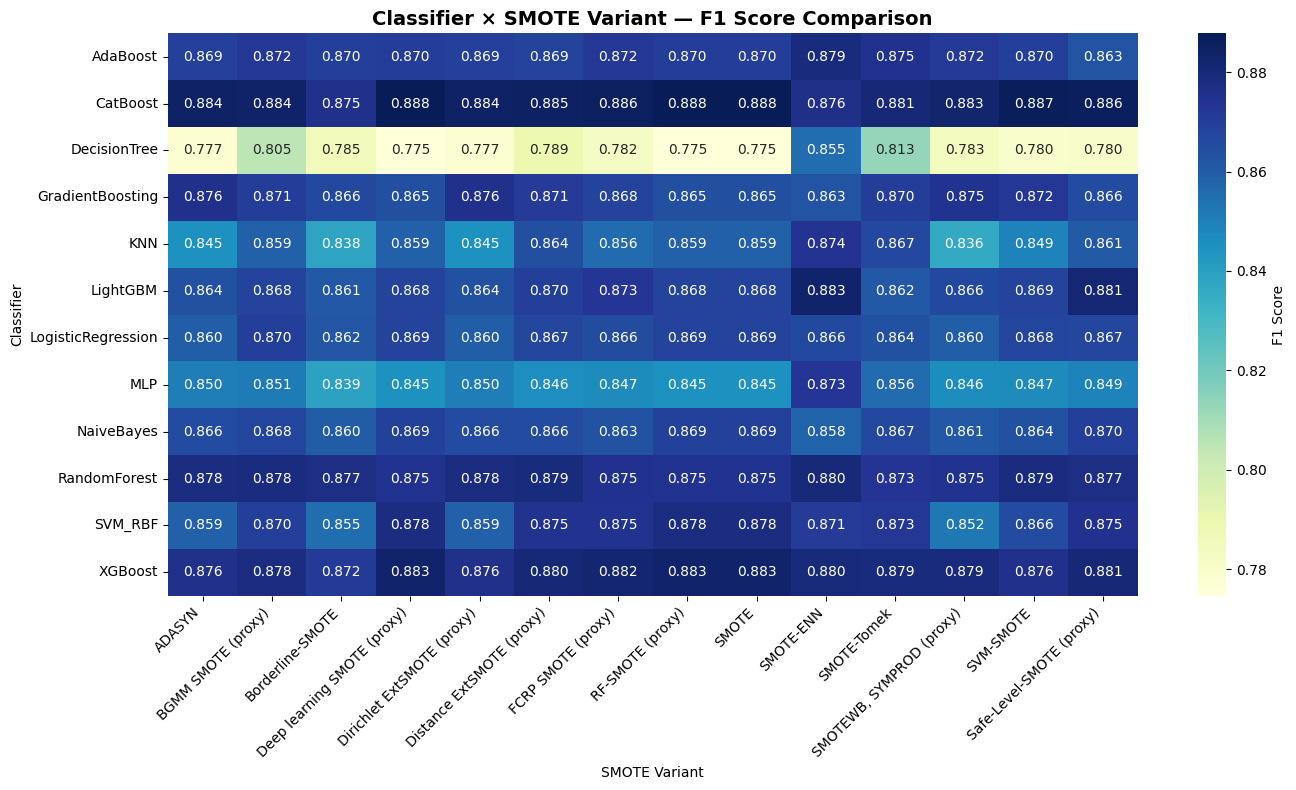

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the table: rows = Classifiers, cols = Variants, values = F1
heatmap_data = grand_df.pivot_table(
    index="Classifier",
    columns="SMOTE_Variant",
    values="F1",
    aggfunc="mean"
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={"label": "F1 Score"}
)
plt.title("Classifier × SMOTE Variant — F1 Score Comparison", fontsize=14, weight="bold")
plt.ylabel("Classifier")
plt.xlabel("SMOTE Variant")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Final Model and Visualization**

Best combo detected:
  Classifier: CatBoost
  Variant   : SMOTE

Using resampler: SMOTE(random_state=42)
Using classifier instance: <catboost.core.CatBoostClassifier object at 0x7f2b43638620>
Train shape after resampling: (812, 15) {1: 406, 0: 406}
Test shape: (184, 15) {1: 102, 0: 82}

Final test-set performance (hold-out 20%):


,Classifier,Variant,Accuracy,Precision,Recall,Specificity,F1,ROC-AUC,PR-AUC
0,CatBoost,SMOTE,0.907609,0.920792,0.911765,0.902439,0.916256,0.939144,0.940457


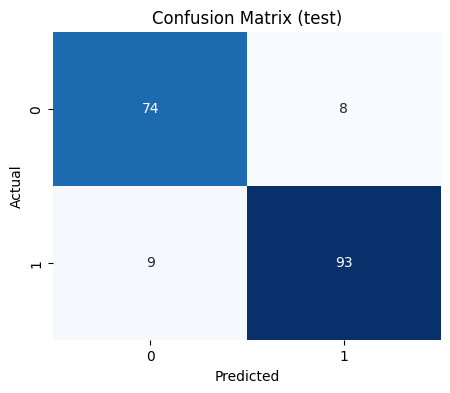

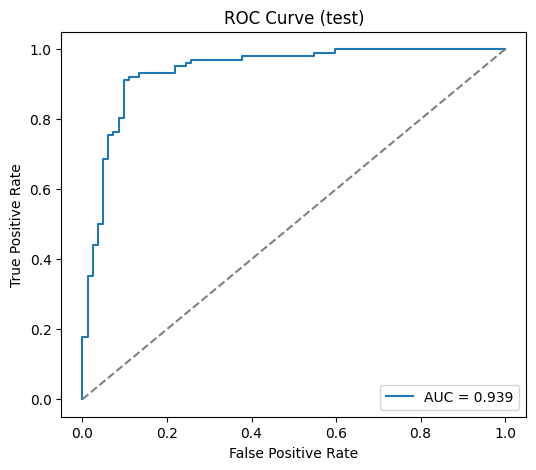

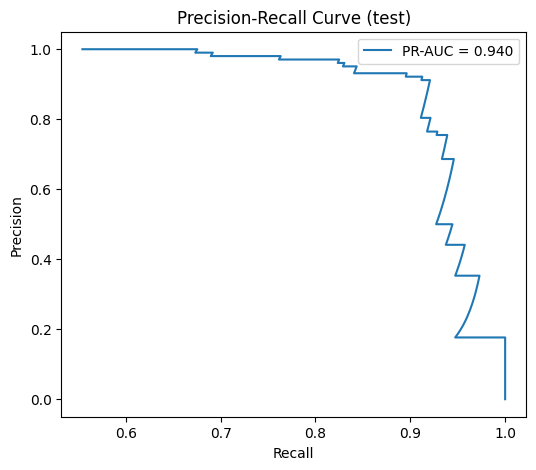

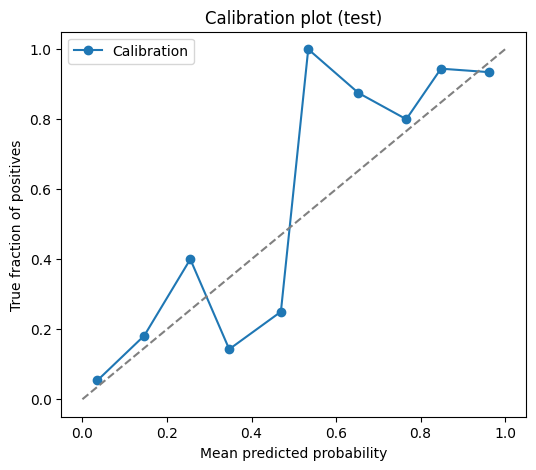

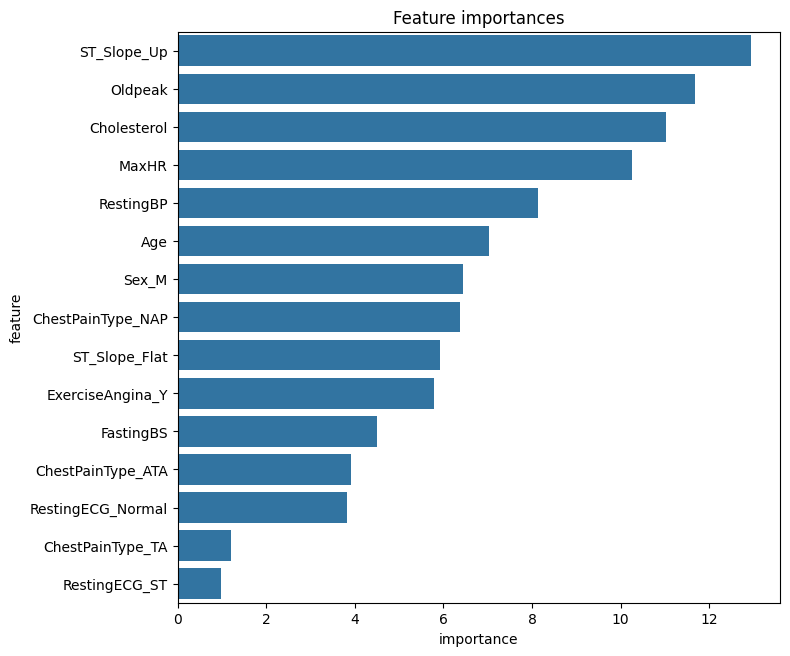

SHAP summary (top features):


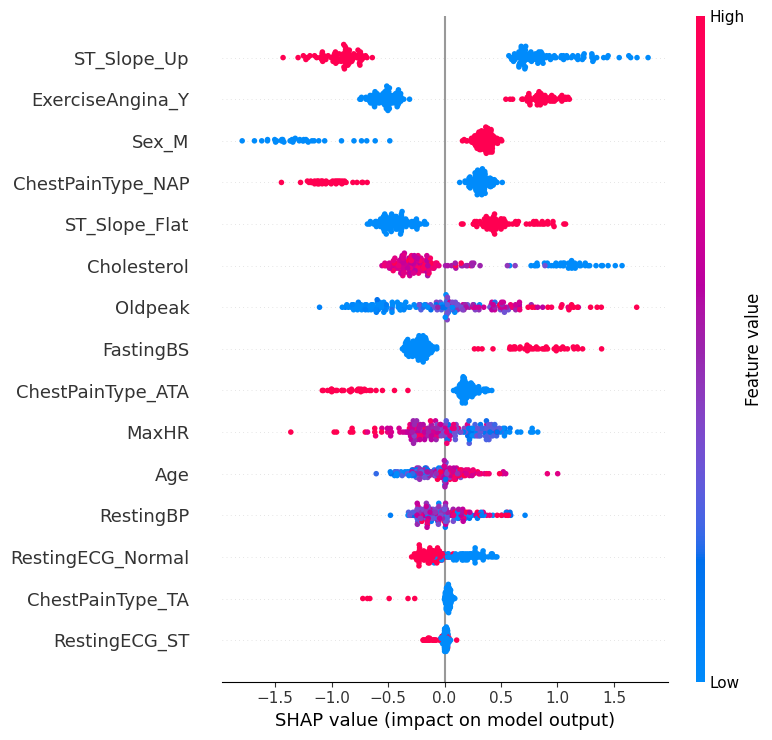

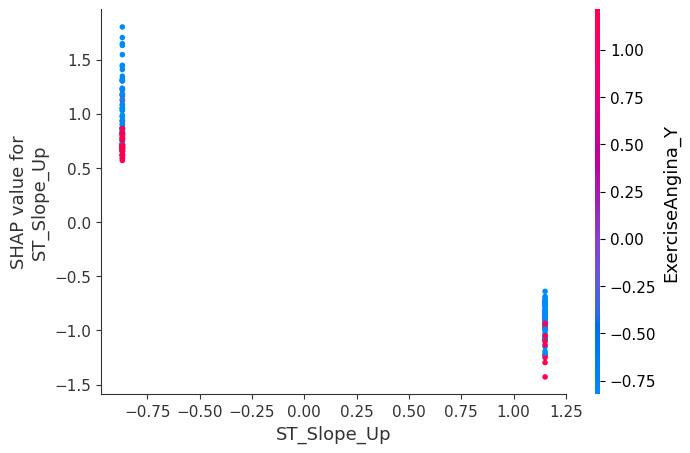


Saved model artifact to: /content/best_model.joblib


In [35]:
# === Train final best model + visualizations ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# Optional: smote_variants if installed
try:
    import smote_variants as sv
except Exception:
    sv = None

# --- 1) Detect best row in grand_df ---
# detect variant column name
variant_col = None
for cand in ["Variant", "SMOTE_Variant", "SMOTE Variant", "SMOTE-VARIANT"]:
    if cand in grand_df.columns:
        variant_col = cand
        break
if variant_col is None:
    # try to infer: grand_df likely has a column that's not 'Variant'
    # assume there's exactly one non-metric string column besides 'Classifier'
    candidate_cols = [c for c in grand_df.columns if grand_df[c].dtype == object]
    # prefer a name that contains "SMOTE" or "variant"
    variant_col = next((c for c in candidate_cols if "SMOTE" in c or "variant" in c.lower()), None)
    if variant_col is None and len(candidate_cols) > 1:
        # pick the second string column if available
        variant_col = candidate_cols[1] if candidate_cols[0] == "Classifier" else candidate_cols[0]

best_row = grand_df.iloc[0]
best_clf_name = best_row.get("Classifier", None)
best_variant_name = best_row.get(variant_col, None) if variant_col else None

print("Best combo detected:")
print("  Classifier:", best_clf_name)
print("  Variant   :", best_variant_name)
print()

# --- 2) Build resampler factory (supports imblearn + proxies used earlier) ---
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

def build_resampler(variant_name):
    if variant_name is None:
        return None
    name = str(variant_name).lower()
    if "smote-enn" in name or "smote_enn" in name:
        return SMOTEENN(random_state=42)
    if "tomek" in name or "smote-tomek" in name:
        return SMOTETomek(random_state=42)
    if "borderline" in name:
        # BorderlineSMOTE (imblearn) exists with kind param
        return BorderlineSMOTE(random_state=42, kind="borderline-1")
    if "svm" in name and "smote" in name:
        return SVMSMOTE(random_state=42)
    if "adasyn" in name:
        return ADASYN(random_state=42)
    if "safe" in name or "safe-level" in name:
        return SMOTE(random_state=42, k_neighbors=3)  # proxy
    if "rf" in name:  # proxy for RF-SMOTE
        return SMOTE(random_state=42, k_neighbors=5)
    if "distance" in name or "dist" in name:
        return SMOTE(random_state=42, k_neighbors=7)
    if "dirichlet" in name:
        return ADASYN(random_state=42, n_neighbors=5)
    if "fcrp" in name:
        return SMOTE(random_state=42, k_neighbors=4)
    if "bgmm" in name or "g_smote" in name:
        # if smote_variants available and G_SMOTE/gaussian exists try that
        if sv is not None and hasattr(sv, "G_SMOTE"):
            return sv.G_SMOTE(random_state=42)
        else:
            return SMOTE(random_state=42)
    if "deep" in name or "gan" in name or "dnn" in name:
        # proxy: use SMOTE with larger k (or sv.GAN_SMOTE if available)
        if sv is not None and hasattr(sv, "GAN_SMOTE"):
            return sv.GAN_SMOTE(random_state=42)
        else:
            return SMOTE(random_state=42, k_neighbors=6)
    if "wb" in name or "symprod" in name:
        return ADASYN(random_state=42, n_neighbors=7)
    # default vanilla SMOTE
    return SMOTE(random_state=42)

resampler = build_resampler(best_variant_name)
print("Using resampler:", resampler)

# --- 3) Get classifier instance from 'classifiers' dict or create new one ---
clf = None
if best_clf_name in classifiers:
    # clone to avoid state carrying
    from sklearn.base import clone
    clf = clone(classifiers[best_clf_name])
else:
    # fallback mapping for common names
    name = str(best_clf_name).lower()
    if "cat" in name and 'CatBoostClassifier' in globals():
        from catboost import CatBoostClassifier
        clf = CatBoostClassifier(verbose=0, random_state=42)
    elif "xgb" in name or "xgboost" in name:
        from xgboost import XGBClassifier
        clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        # last-resort: logistic regression
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

print("Using classifier instance:", clf)

# --- 4) Resample full dataset and do an 80/20 stratified split ---
# Ensure X is DataFrame and y is Series
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)
if not isinstance(y, pd.Series):
    y = pd.Series(y)

# We'll split first, then resample only on the training set (best practice)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

if resampler is not None:
    # smote_variants may use .sample(X.values, y.values) or imblearn uses fit_resample
    try:
        if sv is not None and hasattr(resampler, "sample") and not hasattr(resampler, "fit_resample"):
            X_res_np, y_res_np = resampler.sample(X_train.values, y_train.values)
            X_train_res = pd.DataFrame(X_res_np, columns=X.columns)
            y_train_res = pd.Series(y_res_np)
        else:
            X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
            # ensure DataFrame/Series
            if not isinstance(X_train_res, pd.DataFrame):
                X_train_res = pd.DataFrame(X_train_res, columns=X.columns)
            if not isinstance(y_train_res, pd.Series):
                y_train_res = pd.Series(y_train_res)
    except Exception as e:
        print("Resampler failed, falling back to no resampling. Error:", e)
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
else:
    X_train_res, y_train_res = X_train.copy(), y_train.copy()

print("Train shape after resampling:", X_train_res.shape, y_train_res.value_counts().to_dict())
print("Test shape:", X_test.shape, y_test.value_counts().to_dict())

# --- 5) Fit classifier on resampled train ---
clf.fit(X_train_res, y_train_res)

# --- 6) Evaluate on test set and print metrics table ---
proba_test = get_proba(clf, X_test)
pred_test = (proba_test >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec = recall_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)
roc_auc = roc_auc_score(y_test, proba_test) if len(np.unique(y_test)) > 1 else np.nan
pr_auc = average_precision_score(y_test, proba_test) if len(np.unique(y_test)) > 1 else np.nan
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
specificity = tn / (tn + fp + 1e-12)

metrics_row = pd.DataFrame([{
    "Classifier": best_clf_name,
    "Variant": best_variant_name,
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "Specificity": specificity,
    "F1": f1,
    "ROC-AUC": roc_auc,
    "PR-AUC": pr_auc
}])
print("\nFinal test-set performance (hold-out 20%):")
display(metrics_row)

# --- 7) Visualizations (Confusion matrix, ROC, PR, Calibration, Feature importance, SHAP) ---
plt.rcParams.update({"figure.max_open_warning": 0})

# Confusion matrix heatmap
cm = np.array([[tn, fp],[fn, tp]])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (test)")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (test)")
plt.legend()
plt.show()

# Precision-Recall curve
recall_vals, precision_vals, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(recall_vals, precision_vals, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve (test)")
plt.legend()
plt.show()

# Calibration / Reliability plot
prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration")
plt.plot([0,1],[0,1], linestyle="--", color="grey")
plt.xlabel("Mean predicted probability"); plt.ylabel("True fraction of positives")
plt.title("Calibration plot (test)")
plt.legend()
plt.show()

# Feature importance / coefficients
def plot_feature_importance(est, X, top_n=20):
    if hasattr(est, "feature_importances_"):
        imp = est.feature_importances_
        names = X.columns
        dfimp = pd.DataFrame({"feature": names, "importance": imp}).sort_values("importance", ascending=False).head(top_n)
        plt.figure(figsize=(8, max(4, top_n/3)))
        sns.barplot(x="importance", y="feature", data=dfimp)
        plt.title("Feature importances")
        plt.tight_layout()
        plt.show()
    elif hasattr(est, "coef_"):
        coef = est.coef_.ravel()
        names = X.columns
        dfcoef = pd.DataFrame({"feature": names, "coef": coef}).sort_values("coef", key=abs, ascending=False).head(top_n)
        plt.figure(figsize=(8, max(4, top_n/3)))
        sns.barplot(x="coef", y="feature", data=dfcoef)
        plt.title("Model coefficients (by absolute value)")
        plt.tight_layout()
        plt.show()
    else:
        print("No feature_importances_ or coef_ for this estimator; skipping importance plot.")

plot_feature_importance(clf, X_train_res)

# SHAP summary (try TreeExplainer first)
try:
    import shap
    shap.initjs()
    explainer = None
    if hasattr(clf, "predict_proba") and (hasattr(clf, "feature_importances_") or clf.__class__.__name__.lower().startswith(("cat","lgbm","xgb","random"))):
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test)  # for binary, shap_values may be list
        # If shap_values is list (binary), take the positive class
        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_vals = shap_values[1]
        else:
            shap_vals = shap_values
        print("SHAP summary (top features):")
        shap.summary_plot(shap_vals, X_test, show=True)
        # dependence on top feature
        top_feat = np.argsort(np.abs(shap_vals).mean(0))[-1]
        try:
            shap.dependence_plot(X_test.columns[top_feat], shap_vals, X_test, show=True)
        except Exception:
            pass
    else:
        # KernelExplainer fallback (slower)
        explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X_train_res, 100))
        shap_vals = explainer.shap_values(shap.sample(X_test, 100))
        shap.summary_plot(shap_vals, shap.sample(X_test, 100))
except Exception as e:
    print("SHAP plotting skipped or failed:", e)

# --- 8) Save model ---
out_path = "/content/best_model.joblib"
joblib.dump({"model": clf, "resampler": resampler, "variant": best_variant_name, "classifier_name": best_clf_name}, out_path)
print("\nSaved model artifact to:", out_path)


**Model Performance**

/tmp/ipython-input-1521229184.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


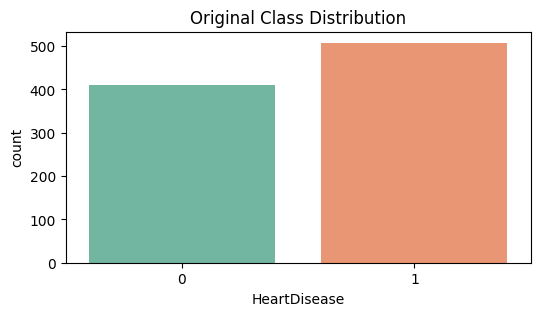

/tmp/ipython-input-1521229184.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="Set1")


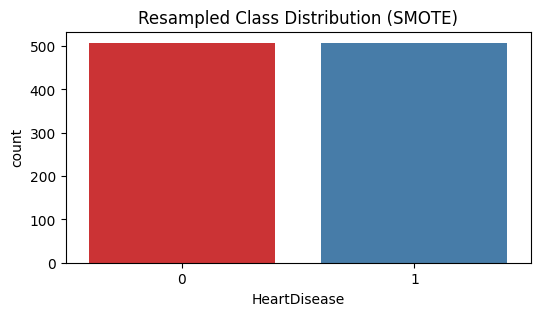

In [36]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE

# Suppose your best variant was "SMOTE"
best_sampler = SMOTE(random_state=42)

X_resampled, y_resampled = best_sampler.fit_resample(X, y)

# Before SMOTE
plt.figure(figsize=(6,3))
sns.countplot(x=y, palette="Set2")
plt.title("Original Class Distribution")
plt.show()

# After SMOTE
plt.figure(figsize=(6,3))
sns.countplot(x=y_resampled, palette="Set1")
plt.title("Resampled Class Distribution (SMOTE)")
plt.show()
